##### Dependencias

In [1]:
%load_ext ipybind

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from IPython.display import clear_output

##### Datos

In [3]:
!wget -q -O datos_retocados.csv "https://www.dropbox.com/scl/fi/xnztguety6brdy7t2lfge/wiki_movie_plots_deduped_sample.csv?rlkey=7m867bh7ruilw66qlh7ozl9g4&dl=1"

In [4]:
global_tabla = pd.read_csv("datos_retocados.csv")

In [5]:
generos_dict = {"western": 0, "science fiction": 1, "romance": 2, "crime": 3}
generos_list = ["western", "science fiction", "romance", "crime"]

In [6]:
def centrar_vector(vec):
    return vec - np.average(vec)

In [7]:
def construir_datos_training(tabla, cantidad_dimensiones, particiones, centrar):
    tokens = np.hstack(tabla["tokens"].apply(lambda x: x.split()).values)
    unique_tokens = pd.Series(tokens).value_counts().index[:cantidad_dimensiones].values
    unique_tokens_dict = dict(zip(unique_tokens, range(len(unique_tokens))))

    tabla_matriz = np.zeros((len(tabla), len(unique_tokens)), dtype=int)
    for i, row in tabla.iterrows():
        for token in row["tokens"].split():
            if unique_tokens_dict.get(token,False)!=False:
                tabla_matriz[i, unique_tokens_dict[token]] += 1

    train_tabla = tabla.loc[tabla["split"] == "train"].to_numpy()
    train_generos = train_tabla[:, 5]
    train_generos = np.array([generos_dict[x] for x in train_generos])
    train_vectores = np.zeros((len(train_generos), len(unique_tokens)), dtype=int)
    for i in range(len(train_tabla)):
        for token in train_tabla[i, 8].split():
            if unique_tokens_dict.get(token,False) != False:
                train_vectores[i, unique_tokens_dict[token]] += 1


    indices_generos = np.array_split(np.arange(len(train_generos)), 4)
    for particion in indices_generos:
        np.random.shuffle(particion)
    
    indices_particiones = []
    for i in range(len(indices_generos)):
        indices_particiones.append(np.array_split(indices_generos[i], particiones))

    indices_permutacion = np.array([], dtype=int)
    for i in range(particiones):
        for gen in range(len(indices_particiones)):
            indices_permutacion = np.concatenate((indices_permutacion, indices_particiones[gen][i]), axis=None)

    if (centrar):
        train_vectores = np.apply_along_axis(centrar_vector, axis=0, arr=train_vectores)

    train_generos = train_generos[indices_permutacion]
    train_vectores = train_vectores[indices_permutacion]

    return train_generos, train_vectores

In [8]:
def construir_datos_testing(tabla, cantidad_dimensiones, centrar):
    tokens = np.hstack(tabla["tokens"].apply(lambda x: x.split()).values)
    unique_tokens = pd.Series(tokens).value_counts().index[:cantidad_dimensiones].values
    unique_tokens_dict = dict(zip(unique_tokens, range(len(unique_tokens))))

    tabla_matriz = np.zeros((len(tabla), len(unique_tokens)), dtype=int)
    for i, row in tabla.iterrows():
        for token in row["tokens"].split():
            if unique_tokens_dict.get(token,False)!=False:
                tabla_matriz[i, unique_tokens_dict[token]] += 1

    test_tabla = tabla.loc[tabla["split"] == "test"].to_numpy()
    test_generos = test_tabla[:, 5]
    test_generos = np.array([generos_dict[x] for x in test_generos])
    test_vectores = np.zeros((len(test_generos), len(unique_tokens)), dtype=int)
    for i in range(len(test_tabla)):
        for token in test_tabla[i, 8].split():
            if unique_tokens_dict.get(token,False) != False:
                test_vectores[i, unique_tokens_dict[token]] += 1

    if (centrar):
        test_vectores = np.apply_along_axis(centrar_vector, axis=0, arr=test_vectores)

    return test_generos, test_vectores

In [9]:
# preguntar que onda que la primer palabra (kill) no tiene apariciones
global_train_g, global_train_v = construir_datos_training(global_tabla, 1000, 4, True)
print(global_train_g.shape)
print(global_train_v.shape)

(320,)
(320, 1000)


In [10]:
global_test_g, global_test_v = construir_datos_testing(global_tabla, 1000, True)
print(global_test_g.shape)
print(global_test_v.shape)

(80,)
(80, 1000)


# KNN

##### Python puro

In [11]:
def productoPuntoPython(vectorA, vectorB):
    producto = 0
    for i in range(len(vectorA)) : 
       producto = vectorA[i]*vectorB[i] + producto
    return producto 

def normaPython(vector):
    valor = 0
    for i in range(len(vector)): 
        valor = vector[i]**2 + valor
    valor = math.sqrt(valor)
    return valor    

def distanciaCosenoPython(vectorA, vectorB):
    # vecA = vectorA - sum(vectorA) / len(vectorA)
    # vecB = vectorB - sum(vectorB) / len(vectorB)
    # distancia = 1 - (productoPunto(vecA, vecB) / (norma(vecA) * norma(vecB)))
    # preguntar media
    norma = normaPython(vectorA) * normaPython(vectorB)
    if norma == 0:
        return np.inf #preguntar
    distancia = 1 - productoPuntoPython(vectorA, vectorB) / norma
    return distancia

In [12]:
def KVecinosPython(vector, modelo_generos, modelo_vectores, k):
    vecinos = []
    for i in range(len(modelo_vectores)): 
        vecinos.append((modelo_generos[i], distanciaCosenoPython(modelo_vectores[i], vector)))
      
    vecinos = sorted(vecinos, key=lambda tup: tup[1])
    kvecinos = []
    for i in range(k):
        kvecinos.append(vecinos[i][0])
    return kvecinos

def KNNPython(vector, modelo_generos, modelo_vectores, k):
    aparicionesDeClase = [0,0,0,0]

    kvecinos = KVecinosPython(vector, modelo_generos, modelo_vectores, k)

    for vecino in kvecinos:
        aparicionesDeClase[vecino] = aparicionesDeClase[vecino] + 1
    
    maxIndice = 0
    maxApariciones = 0       
    for i in range(len(aparicionesDeClase)):
        if(aparicionesDeClase[i] > maxApariciones):
            maxIndice = i
            maxApariciones = aparicionesDeClase[i]
    return generos_list[maxIndice]

In [13]:
modelo_generos = global_train_g[80:]
modelo_vectores = global_train_v[80:]
for i in range(80):
    vector = global_train_v[i]
    genero_esperado = generos_list[global_train_g[i]]
    print("Esperado: " + genero_esperado + " Resultado: " + KNNPython(vector, modelo_generos, modelo_vectores, 10))

Esperado: crime Resultado: western
Esperado: crime Resultado: romance
Esperado: crime Resultado: crime
Esperado: crime Resultado: romance
Esperado: crime Resultado: crime
Esperado: crime Resultado: western
Esperado: crime Resultado: crime
Esperado: crime Resultado: crime
Esperado: crime Resultado: western
Esperado: crime Resultado: romance
Esperado: crime Resultado: crime
Esperado: crime Resultado: crime
Esperado: crime Resultado: romance
Esperado: crime Resultado: romance
Esperado: crime Resultado: crime
Esperado: crime Resultado: crime
Esperado: crime Resultado: crime
Esperado: crime Resultado: romance
Esperado: crime Resultado: crime
Esperado: crime Resultado: romance
Esperado: romance Resultado: romance
Esperado: romance Resultado: romance
Esperado: romance Resultado: romance
Esperado: romance Resultado: romance
Esperado: romance Resultado: romance
Esperado: romance Resultado: romance
Esperado: romance Resultado: crime
Esperado: romance Resultado: romance
Esperado: romance Resultad

##### Numpy

In [14]:
def normaNumpy(vector):
    return np.linalg.norm(vector)

def distanciaCosenoNumpy(vectorA, vectorB):
    # vecA = vectorA - np.average(vectorA)
    # vecB = vectorB - np.average(vectorB)
    # if (normaNumpy(vecA) == 0 or normaNumpy(vecB) == 0):
    #     return np.inf # preguntar
    # return 1 - (np.dot(vecA, vecB) / (normaNumpy(vecA) * normaNumpy(vecB)))
    norma = normaNumpy(vectorA) * normaNumpy(vectorB)
    if norma == 0:
        return np.inf #preguntar
    return 1 - (np.dot(vectorA, vectorB) / norma)

In [15]:
def KVecinosNumpy(vector, modelo_generos, modelo_vectores, k):
    vecinos = np.zeros((len(modelo_generos), 2))
    vecinos[:, 0] = modelo_generos
    vecinos[:, 1] = [distanciaCosenoNumpy(vector, x) for x in modelo_vectores]
        
    vecinos = vecinos[vecinos[:, 1].argsort()]
    kvecinos = np.array(vecinos[:k, 0], dtype=int)
    return kvecinos


def KNNNumpy(vector, modelo_generos, modelo_vectores, k):
    kvecinos = KVecinosNumpy(vector, modelo_generos, modelo_vectores, k)
    return scipy.stats.mode(kvecinos).mode

In [16]:
def promedio_knn(tabla, cantidad_dims, tamano_part, k):
    g, v = construir_datos_training(tabla, cantidad_dims, 4, False)
    modelo_generos = g[tamano_part:]
    modelo_vectores = v[tamano_part:]
    correctos = 0.0
    for i in range(tamano_part):
        vector = v[i]
        genero_esperado = g[i]
        if genero_esperado == KNNNumpy(vector, modelo_generos, modelo_vectores, k):
            correctos = correctos + 1
    return correctos / tamano_part

In [17]:
np.average([promedio_knn(global_tabla, 1000, 80, 7) for i in range(100)])

np.float64(0.7484999999999999)

##### KNN Partido

In [18]:
# Partimos KNN para poder optimizar la exploracion de k y p
class KNN:
    def __init__(self):
        self.vecinos_ordenados = np.array([0])
        
    def calcular_distancias(self, vector, modelo_generos, modelo_vectores):
        vecinos = np.zeros((len(modelo_generos), 2))
        vecinos[:, 0] = modelo_generos
        vecinos[:, 1] = [distanciaCosenoNumpy(vector, x) for x in modelo_vectores]
        self.vecinos_ordenados = vecinos[vecinos[:, 1].argsort()]

    def clasificar(self, k):
        kvecinos = np.array(self.vecinos_ordenados[:k, 0], dtype=int)
        return scipy.stats.mode(kvecinos).mode

# Método de la potencia

##### Implementacion en C++ del metodo de la potencia con deflacion

In [19]:
%%pybind11

#include <iostream>
#include <pybind11/numpy.h>
#include <eigen3/Eigen/Dense>
#include <pybind11/eigen.h>
#include <math.h>
#include <tuple>
#include <vector>
#include <pybind11/stl.h>

using namespace std;
using namespace Eigen;

tuple<double, VectorXd, int> calcular_dominantes(const MatrixXd& matriz, const double tolerancia, const int limite_pasos) {
    VectorXd v_old = VectorXd::Random(matriz.cols());
    v_old = v_old.normalized();
    VectorXd v_new = VectorXd(matriz.cols());
    double diff = 1000000.0;
    int donde_termino = 0;
    for (int i = 0; i < limite_pasos && diff > tolerancia; i++) { 
        v_new = (matriz*v_old).normalized();
        diff = (v_old - v_new).lpNorm<Infinity>();
        v_old = v_new;
        donde_termino++;
    }
    double autovalor = (v_old.transpose() * matriz * v_old)[0] / (v_old.transpose() * v_old)[0];
    return {autovalor, v_old.normalized(), donde_termino};
}

void desinflar(MatrixXd& matriz, const double autoval, VectorXd autovec) {
    matriz = matriz - autoval * autovec * autovec.transpose();
}

vector<tuple<double, VectorXd, int>> metodo_potencia_deflacion(const MatrixXd& matriz, const double tolerancia, const int limite_pasos, int cant_auto) {
    MatrixXd mat = matriz;
    if (cant_auto == -1) cant_auto = mat.cols();
    vector<tuple<double, VectorXd, int>> res = {};
    for (int i = 0; i < mat.cols() && i < cant_auto; i++) {
        tuple<double, VectorXd, int> doms;
        doms = calcular_dominantes(mat, tolerancia, limite_pasos);
        res.push_back(doms);
        desinflar(mat, get<0>(doms), get<1>(doms));
    }
    return res;
}

PYBIND11_PLUGIN(metodo_potencia) {
    py::module m("metodo_potencia_con_deflacion");
    m.def("metodo_potencia_deflacion", [](const MatrixXd& matriz, const double tolerancia, const int limite_pasos, const int cant_auto) {
        return metodo_potencia_deflacion(matriz, tolerancia, limite_pasos, cant_auto);
    });
    m.def("primeros_autos", [](const MatrixXd& matriz, const double tolerancia, const int limite_pasos) {
        return calcular_dominantes(matriz, tolerancia, limite_pasos);
    });
    return m.ptr();
}

##### Prueba de correctitud con Householder

In [19]:
n = 50
for i in range(1, 101): 
    print("Probando matriz " + str(i))
    autovalores_esperados = np.array(range(n, 0, -1), dtype=np.float64) * i

    D = np.diag(autovalores_esperados)
    v = np.random.normal(size=(n, 1))
    v = v / np.linalg.norm(v)
    H = np.eye(n) - 2 * (v @ v.T)
    M = H @ D @ H.T
    M = M.astype(np.float64)
    # M es simetrica y tiene autovalores l1 > l2 > ... > l50 > 0
    # Asi que cumple los requisitos
    
    res = metodo_potencia_deflacion(M, 1e-10, 1000000, -1)

    for j in range(n):
        assert(np.isclose(autovalores_esperados[j], res[j][0]))
        assert(np.allclose(H[j, :], res[j][1]) or np.allclose(H[j, :], res[j][1] * -1)) # Preguntar or
        # Por la forma en la que lo construimos, la columna j de H es el autovector asociado al autovalor lj
        # que al mismo tiempo es el elemento j de la diagonal D. Tambien por lo mismo ya estan normalizados
        # y los que nos devuelve el algoritmo tambien estan normalizados, solo queda tener cuidado con
        # que el sentido sea el opuesto.

print("Todas las matrices dieron bien!")


Probando matriz 1
Probando matriz 2
Probando matriz 3
Probando matriz 4
Probando matriz 5
Probando matriz 6
Probando matriz 7
Probando matriz 8
Probando matriz 9
Probando matriz 10
Probando matriz 11
Probando matriz 12
Probando matriz 13
Probando matriz 14
Probando matriz 15
Probando matriz 16
Probando matriz 17
Probando matriz 18
Probando matriz 19
Probando matriz 20
Probando matriz 21
Probando matriz 22
Probando matriz 23
Probando matriz 24
Probando matriz 25
Probando matriz 26
Probando matriz 27
Probando matriz 28
Probando matriz 29
Probando matriz 30
Probando matriz 31
Probando matriz 32
Probando matriz 33
Probando matriz 34
Probando matriz 35
Probando matriz 36
Probando matriz 37
Probando matriz 38
Probando matriz 39
Probando matriz 40
Probando matriz 41
Probando matriz 42
Probando matriz 43
Probando matriz 44
Probando matriz 45
Probando matriz 46
Probando matriz 47
Probando matriz 48
Probando matriz 49
Probando matriz 50
Probando matriz 51
Probando matriz 52
Probando matriz 53
Pr

##### Error y velocidad de convergencia

In [133]:
def error_y_velocidad_convergencia():
    epsilons = np.logspace(-4, 0, 10)
    res_errores = []
    res_pasos = []
    for e in epsilons:

        D = np.diag([10., 10. - e, 5., 2., 1.])
        v = np.random.normal(size=(5, 1))
        v = v / np.linalg.norm(v)
        H = np.eye(5) - 2 * (v @ v.T)
        M = H @ D @ H.T

        valores = [metodo_potencia_deflacion(M, 1e-7, 1000000, -1) for veces in range(100)]

        # Error para cada autovalor (y autovector)
        errores = np.array([[np.linalg.norm(M @ v[i][1] - v[i][0] * v[i][1]) for i in range(len(v))] for v in valores])
        promedios_errores = np.apply_along_axis(np.average, axis=0, arr=errores)
        
        # Velocidad de convergencia para el autovalor que tarda mas por tener dos parecidos
        pasos = [v[0][2] for v in valores]
        promedio_pasos = np.average(pasos)

        res_errores.append(promedios_errores)
        res_pasos.append(promedio_pasos)
    return epsilons, res_errores, res_pasos

In [134]:
epsilons_graficar, errores_graficar, pasos_graficar = error_y_velocidad_convergencia()

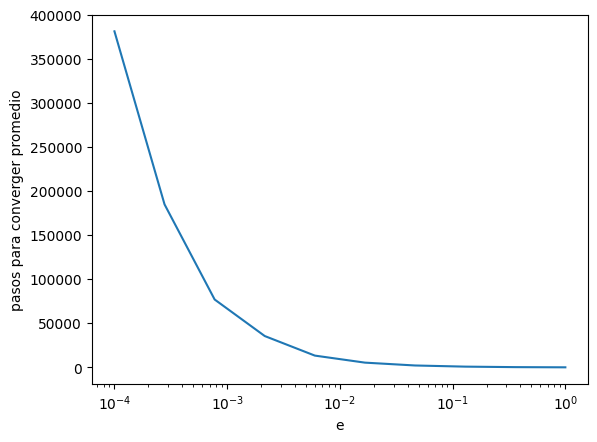

In [267]:
plt.plot(epsilons_graficar, pasos_graficar)
plt.ylabel("pasos para converger promedio")
plt.xlabel("e")
plt.xscale("log")

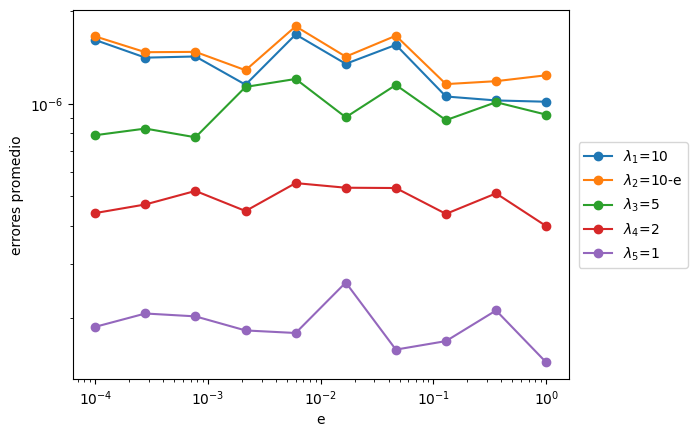

In [268]:
plt.plot(epsilons_graficar, errores_graficar, '-o')
plt.ylabel("errores promedio")
plt.xlabel("e")
plt.xscale("log")
plt.yscale("log")
plt.legend(["$\lambda_1$=10", "$\lambda_2$=10-e", "$\lambda_3$=5", "$\lambda_4$=2", "$\lambda_5$=1"], loc=[1.02,0.3]);

# PCA

##### PCA

In [20]:
class PCA:
    def __init__(self):
        self.V = np.array([0])
        self.autovalores = np.array([0])

    def fit(self, matriz):
        matriz_covarianza = (matriz.T @ matriz) / (matriz.shape[0] - 1) 
        autos = metodo_potencia_deflacion(matriz_covarianza, 1e-8, 1000, -1)
        self.V = np.array([autos[i][1] for i in range(len(autos))])
        self.autovalores = np.array([autos[i][0] for i in range(len(autos))])

    def transform_matriz(self, matriz, componentes):
        return matriz @ self.V[:, :componentes]
    
    def transform_vector(self, vector, componentes):
        return vector.T @ self.V[:, :componentes]
    
    def shape(self):
        return self.V.shape
    
    def varianza_explicada(self, cantidad):
        return self.autovalores[:cantidad]

# Clasificacion

##### Clasificador

In [184]:
def clasificar(vector, modelo_generos, modelo_vectores):
    return KNNNumpy(vector, modelo_generos, modelo_vectores, 5)

In [250]:
def performance_clasificador(tabla, cantidad_dimensiones):
    generos, vectores = construir_datos_training(tabla, cantidad_dimensiones, 5)

    correctos = 0
    tamano_particion = int(len(generos) / 5) # 20% por particion
    modelo_generos = generos[tamano_particion:]
    modelo_vectores = vectores[tamano_particion:]

    for i in range(tamano_particion):
        vector = vectores[i]
        genero_esperado = generos[i]
        genero_res = clasificar(vector, modelo_generos, modelo_vectores)
        if genero_esperado == genero_res:
            correctos = correctos + 1
    return correctos / tamano_particion

In [260]:
performances_knn = [sum([performance_clasificador(global_tabla, q) for veces in range(100)]) for q in [500, 1000, 5000]]
promedios_performances_knn = [p / 100 for p in performances_knn]
print(promedios_performances_knn)

[0.666875, 0.660625, 0.6615625]


##### Mejor k sin PCA

In [263]:
def kfold(tabla, cantidad_dimensiones, particiones, vecinos):
    generos, vectores = construir_datos_training(tabla, cantidad_dimensiones, 4)

    correctos = 0
    tamano_particion = int(len(generos) / particiones)
    for i in range(particiones):
        azul_start = i * tamano_particion
        azul_end = i * tamano_particion + tamano_particion
        modelo_generos = np.concatenate((generos[:azul_start], generos[azul_end:]))
        modelo_vectores = np.concatenate((vectores[:azul_start], vectores[azul_end:]))
        for j in range(azul_start, azul_end):
            vector = vectores[j]
            genero_esperado = generos[j]
            genero_res = KNNNumpy(vector, modelo_generos, modelo_vectores, vecinos)
            if genero_esperado == genero_res:
                correctos = correctos + 1
    return correctos / len(generos)

In [265]:
performances_k_sin_pca = np.zeros((240, 3))
for k in range(1, 241):
    performances = [kfold(global_tabla, q, 4, k) for q in [500, 1000, 5000]]
    performances_k_sin_pca[k-1, :] = performances

In [279]:
np.argmax(performances_k_sin_pca, axis=0)
print(performances_k_sin_pca[73][0])
print(performances_k_sin_pca[66][1])
print(performances_k_sin_pca[20][2])

0.725
0.715625
0.715625


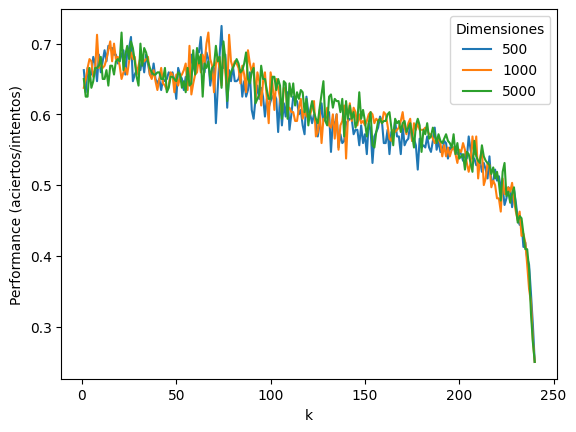

In [281]:
plt.plot(np.arange(1, 241), performances_k_sin_pca)
plt.ylabel("Performance (aciertos/intentos)")
plt.xlabel("k")
plt.legend(["500", "1000", "5000"], title="Dimensiones");

##### Varianza

In [27]:
def varianza(tabla, cantidad_dimensiones):
    generos, vectores = construir_datos_training(tabla, cantidad_dimensiones, 4)

    tamano_particion = int(len(generos) / 4)
    varianzas = []

    pca = PCA()

    for i in range(4):
        azul_start = i * tamano_particion
        azul_end = i * tamano_particion + tamano_particion
        modelo_vectores = np.concatenate((vectores[:azul_start], vectores[azul_end:]))

        pca.fit(modelo_vectores)
        varianzas.append(pca.varianza_explicada(1000))
    
    return varianzas

In [28]:
varianzas_explicadas = varianza(global_tabla, 1000)

In [51]:
varianzas_totales = [np.sum(v) for v in varianzas_explicadas]
varianzas_porcentajes = [[v / varianzas_totales[i] for v in varianzas_explicadas[i]] for i in range(4)]
varianzas_acumuladas = [np.cumsum(v) for v in varianzas_porcentajes]

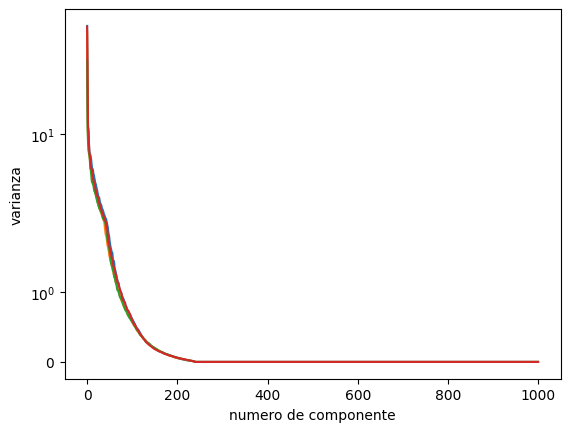

In [54]:
for v in varianzas_explicadas:
    plt.plot(v)
plt.xlabel("numero de componente")
plt.ylabel("varianza")
plt.yscale("symlog");

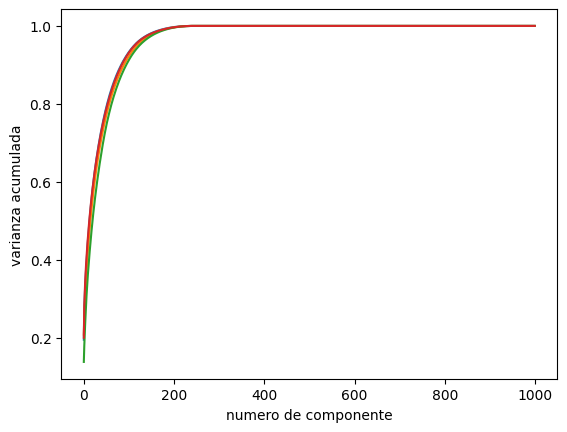

In [53]:
for v in varianzas_acumuladas:
    plt.plot(v)
plt.xlabel("numero de componente")
plt.ylabel("varianza acumulada");

##### Exploracion de p y k

In [27]:
def print_progreso_mejores(fold, p, k):
    print("Fold: " + str(fold))
    if p == -1:
        print("Fitteando...")
    else:
        print("p: " + str(p))
        print("k: " + str(k))

In [21]:
def mejorKyP(tabla, cantidad_dimensiones):
    generos, vectores = construir_datos_training(tabla, cantidad_dimensiones, 4, False)
    tamano_particion = int(len(generos) / 4)
    pca = PCA()
    knn = KNN()

    limite_k = 240
    limite_p = 300
    step_k = 1
    step_p = 1
    ks = np.array(np.arange(1, limite_k+1, step_k))
    ps = np.array(np.arange(1, limite_p+1, step_p))
    vs = np.zeros((len(ks), len(ps)), dtype=np.float64)

    for i in range(4):
        azul_start = i * tamano_particion
        azul_end = i * tamano_particion + tamano_particion
        modelo_generos = np.concatenate((generos[:azul_start], generos[azul_end:]))
        modelo_vectores = np.concatenate((vectores[:azul_start], vectores[azul_end:]))

        #cuidado con los prints, a veces se rompe
        #print_progreso_mejores(i+1, -1, -1)
        pca.fit(modelo_vectores)
        for p in range(1, limite_p+1, step_p):
            modelo_vectores_recortado = pca.transform_matriz(modelo_vectores, p)

            for j in range(azul_start, azul_end):
                vector = vectores[j]
                vector = pca.transform_vector(vector, p)
                genero_esperado = generos[j]

                knn.calcular_distancias(vector, modelo_generos, modelo_vectores_recortado)

                for k in range(1, limite_k+1, step_k):
                    #print_progreso_mejores(i+1, p, k)

                    genero_res = knn.clasificar(k)

                    if genero_esperado == genero_res:
                        vs[int(math.ceil(k/step_k))-1][int(math.ceil(p/step_p))-1] += 1
    
    for p in range(len(ps)):
        for k in range(len(ks)):
            vs[k][p] = vs[k][p] / len(generos)
    return ks, ps, vs

In [22]:
# CUIDADO, tarda 74 minutos
ks_graficar, ps_graficar, vs_graficar = mejorKyP(global_tabla, 1000)

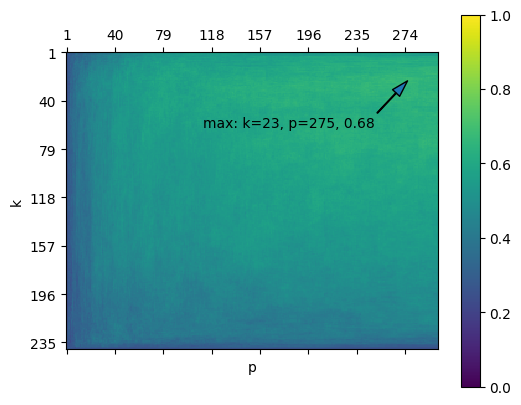

In [75]:
plt.matshow(vs_graficar, vmin=0, vmax=1)
plt.xticks(np.arange(0, len(ps_graficar), 39), ps_graficar[np.arange(0, len(ps_graficar), 39)])
plt.yticks(np.arange(0, len(ks_graficar), 39), ks_graficar[np.arange(0, len(ks_graficar), 39)])
plt.xlabel("p")
plt.ylabel("k")
#plt.arrow(275, 23, 1, 1, edgecolor="red")
plt.annotate("max: k=23, p=275, 0.68", (275, 23), (110, 60), arrowprops={"width": 0.5, "headwidth": 7})
plt.colorbar();

In [76]:
ind = np.unravel_index(np.argmax(vs_graficar, axis=None), vs_graficar.shape) 
print(ks_graficar[ind[0]])
print(ps_graficar[ind[1]])
print(vs_graficar[ind])

23
275
0.684375


##### Clasificador con p y k optimos

In [31]:
def clasificarConKyP(tabla, cantidad_dimensiones, p, k):
    modelo_generos, modelo_vectores = construir_datos_training(tabla, cantidad_dimensiones, 4, False)
    test_generos, test_vectores = construir_datos_testing(tabla, cantidad_dimensiones, False)
    pca = PCA()
    knn = KNN()
    correctos = 0

    print("Fitteando...")
    pca.fit(modelo_vectores)
    modelo_vectores_recortado = pca.transform_matriz(modelo_vectores, p)

    print("Testeando...")
    for i in range(len(test_generos)):
        vector = pca.transform_vector(test_vectores[i], p)
        genero_esperado = test_generos[i]
        genero_res = KNNNumpy(vector, modelo_generos, modelo_vectores_recortado, k)
        if genero_esperado == genero_res:
            correctos += 1

    return correctos / len(test_generos)

In [32]:
clasificarConKyP(global_tabla, 1000, 275, 23)

Fitteando...
Testeando...


0.8125